Librerias

In [1]:
!pip install pycaret
!pip install sweetviz
import sweetviz as sv
import gdown
import subprocess
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy import signal,stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
from pycaret.classification import *
from sklearn.impute import SimpleImputer



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 743.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

Carga de datos

In [2]:
def download_and_extract(file_url, zip_filename):
    print(f"Descargando {zip_filename}...")
    gdown.download(file_url, zip_filename, quiet=False)

    if not os.path.exists(zip_filename):
        print(f"Error: No se pudo descargar {zip_filename}")
        return
    print(f"Descomprimiendo {zip_filename}...")
    result = subprocess.run(['7z', 'x', zip_filename], capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Error al descomprimir: {result.stderr}")
    else:
        print("Archivo descomprimido exitosamente")
    os.remove(zip_filename)


file_url = 'https://drive.google.com/uc?id=1-gPUwktqqzMALAC7jossX_AYuohRF1Hr'
zip_filename = 'space_apps_2024_seismic_detection.zip'

download_and_extract(file_url, zip_filename)

Descargando space_apps_2024_seismic_detection.zip...


Downloading...
From (original): https://drive.google.com/uc?id=1-gPUwktqqzMALAC7jossX_AYuohRF1Hr
From (redirected): https://drive.google.com/uc?id=1-gPUwktqqzMALAC7jossX_AYuohRF1Hr&confirm=t&uuid=45b5a546-81f2-4377-a04b-d1d8e06971c7
To: /content/space_apps_2024_seismic_detection.zip
100%|██████████| 2.26G/2.26G [00:32<00:00, 70.4MB/s]


Descomprimiendo space_apps_2024_seismic_detection.zip...
Archivo descomprimido exitosamente


Explorar base de datos LUNAR

In [12]:
LunarCatalogo = "/content/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA"
DataframesLunar=[]
csv_files = [f for f in os.listdir(LunarCatalogo) if f.endswith('.csv')]
print(len(csv_files))


76


In [117]:
correctos = pd.read_csv(os.path.join('/content/space_apps_2024_seismic_detection/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'))
correctos.columns = ['filename', 'fecha', 'time_rel(sec)','evidencia','tipo']
fechas_dict = correctos.groupby('filename')['time_rel(sec)'].apply(list).to_dict()
#print(fechas_dict)
def encontrar_coincidencias(x, fechas_validas, tolerancia=0.001):
    return np.any(np.abs(fechas_validas - x) <= tolerancia)

def DataTrain(path,marte=False):
  df = pd.read_csv(path)
  df.columns = ['fecha','time_rel(sec)', 'velocity(m/s)']
  if marte:
    df['velocity(m/s)'] = df['velocity(m/s)']/100
  df['acceleration'] = df['velocity(m/s)'].diff() / df['time_rel(sec)'].diff()
  df['acceleration'] = df['acceleration'].fillna(0)
  df['dif_velocidad'] = df['velocity(m/s)'].diff().fillna(0)
  tr_times_filt = np.array(df['time_rel(sec)'])
  tr_data_filt = np.array(df['velocity(m/s)'])
  freq=[0]
  for i in range(1,len(df['velocity(m/s)'])):
    freq.append(abs(tr_data_filt[i])/(tr_times_filt[i]-tr_times_filt[i-1]))
  df['freq']=freq
  df['dif_frecuencia']=df['freq'].diff().fillna(0)
  return df
def filtrar(df,fechas_dict,fechas):
  media = np.mean(df['velocity(m/s)'])
  desviacion_estandar = np.std(df['velocity(m/s)'])
  df['etiquetas'] = 0
  file_key = filename[:-4]
  if file_key in fechas.keys():
      fechas_validas = np.array(fechas[file_key])
      df['etiquetas'] = df['time_rel(sec)'].apply(lambda x: encontrar_coincidencias(x, fechas_validas))
  df_no_sismos = df[df['etiquetas'] == 0]
  df_no_sismos = df_no_sismos[df_no_sismos['velocity(m/s)'] > (media + desviacion_estandar)]
  media_filtrada = np.mean(df_no_sismos['velocity(m/s)'])
  desviacion_estandar_filtrada = np.std(df_no_sismos['velocity(m/s)'])
  df_no_sismos = df_no_sismos[df_no_sismos['velocity(m/s)'] > (media_filtrada + desviacion_estandar_filtrada)]
  umbral_percentil_98 = np.percentile(df_no_sismos['velocity(m/s)'], 98)
  df_no_sismos = df_no_sismos[df_no_sismos['velocity(m/s)'] > umbral_percentil_98]
  df_final = pd.concat([df[df['etiquetas'] == 1], df_no_sismos])
  return df_final


def DataTest(path):
  df= pd.read_csv(path)
  df.columns = ['fecha','time_rel(sec)', 'velocity(m/s)']
  df['dif_velocidad'] = df['velocity(m/s)'].diff().fillna(0)
  df['acceleration'] = df['velocity(m/s)'].diff() / df['time_rel(sec)'].diff()
  tr_times_filt = np.array(df['time_rel(sec)'])
  tr_data_filt = np.array(df['velocity(m/s)'])
  freq=[0]
  for i in range(1,len(df['velocity(m/s)'])):
    freq.append(abs(tr_data_filt[i])/(tr_times_filt[i]-tr_times_filt[i-1]))
  df['freq']=freq
  df['dif_frecuencia']=df['freq'].diff().fillna(0)
  df.dropna()
  return df, df.copy()


for filename in tqdm(csv_files):
  file_path = os.path.join(LunarCatalogo, filename)
  df = DataTrain(file_path,False)
  df_final = filtrar(df,correctos,fechas_dict)
  DataframesLunar.append(df_final)
df = pd.concat(DataframesLunar, ignore_index=True)


100%|██████████| 76/76 [08:41<00:00,  6.86s/it]


Analisis estadistico

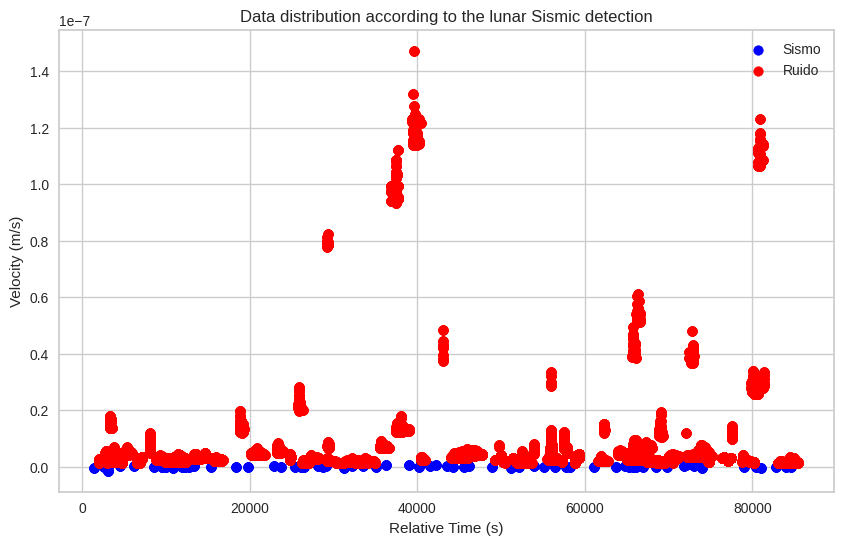

In [46]:
plt.figure(figsize=(10, 6))

df1 = df[df['etiquetas'] == 1]
plt.scatter(df1['time_rel(sec)'], df1['velocity(m/s)'], color='blue', label='Sismo')
df2 = df[df['etiquetas'] == 0]
plt.scatter(df2['time_rel(sec)'], df2['velocity(m/s)'], color='red', label='Ruido')
plt.xlabel('Relative Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Data distribution according to the lunar Sismic detection')
plt.legend()
plt.show()

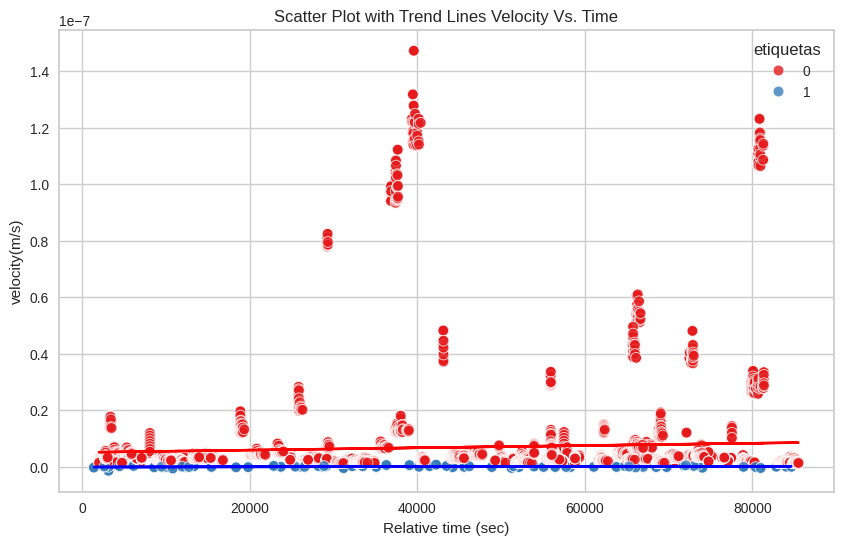

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='time_rel(sec)', y='velocity(m/s)', hue='etiquetas', palette='Set1', s=60, alpha=0.8)
colores = ['red', 'blue']
for etiqueta in df['etiquetas'].unique():
    df_group = df[df['etiquetas'] == etiqueta]
    coef = np.polyfit(df_group['time_rel(sec)'], df_group['velocity(m/s)'], 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(df_group['time_rel(sec)'], poly1d_fn(df_group['time_rel(sec)']), color=colores[etiqueta])
plt.title('Scatter Plot with Trend Lines Velocity Vs. Time')
plt.xlabel('Relative time (sec)')
plt.ylabel('velocity(m/s)')
plt.show()

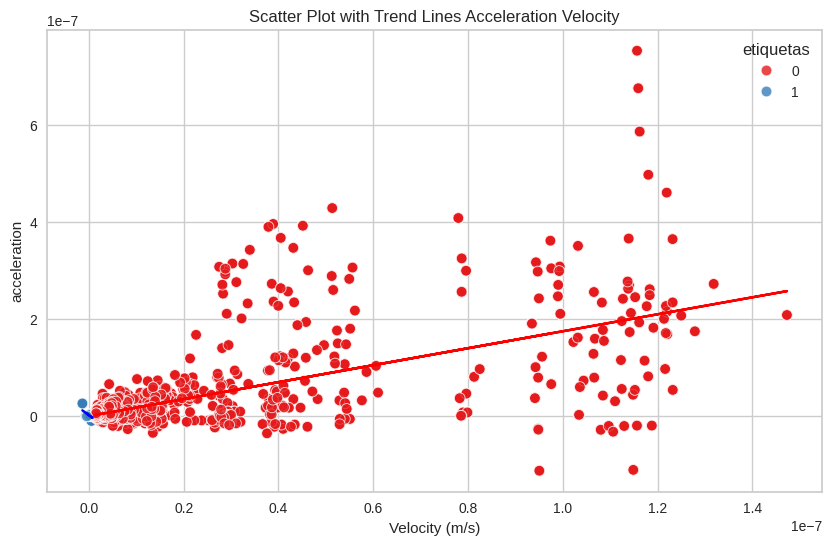

In [51]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='velocity(m/s)', y='acceleration', hue='etiquetas', palette='Set1', s=60, alpha=0.8)

colores = ['red', 'blue']
for etiqueta in df['etiquetas'].unique():
    df_group = df[df['etiquetas'] == etiqueta]
    coef = np.polyfit(df_group['velocity(m/s)'], df_group['acceleration'], 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(df_group['velocity(m/s)'], poly1d_fn(df_group['velocity(m/s)']), color=colores[etiqueta])
plt.title('Scatter Plot with Trend Lines Acceleration Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('acceleration')
plt.show()

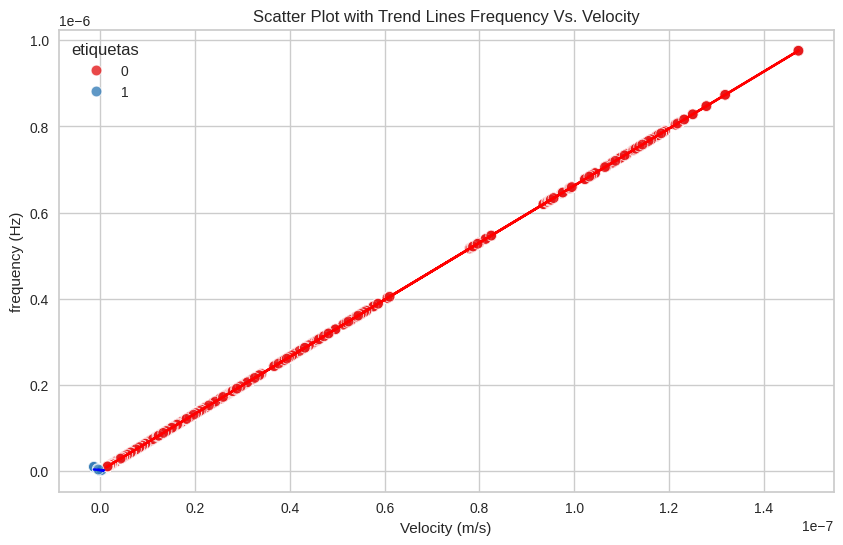

In [54]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='velocity(m/s)', y='freq', hue='etiquetas', palette='Set1', s=60, alpha=0.8)

colores = ['red', 'blue']
for etiqueta in df['etiquetas'].unique():
    df_group = df[df['etiquetas'] == etiqueta]
    coef = np.polyfit(df_group['velocity(m/s)'], df_group['freq'], 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(df_group['velocity(m/s)'], poly1d_fn(df_group['velocity(m/s)']), color=colores[etiqueta])
plt.title('Scatter Plot with Trend Lines Frequency Vs. Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('frequency (Hz)')
plt.show()

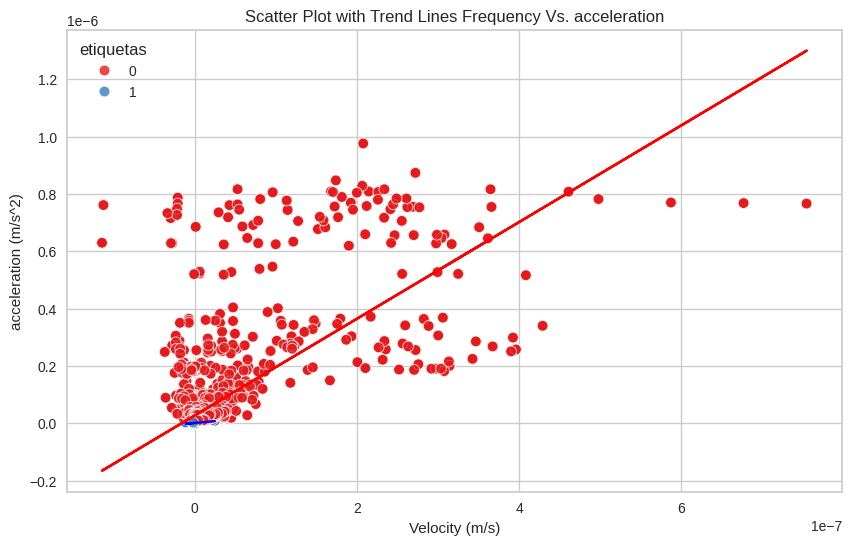

In [57]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='acceleration', y='freq', hue='etiquetas', palette='Set1', s=60, alpha=0.8)


colores = ['red', 'blue']
for etiqueta in df['etiquetas'].unique():
    df_group = df[df['etiquetas'] == etiqueta]
    coef = np.polyfit(df_group['acceleration'], df_group['freq'], 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(df_group['acceleration'], poly1d_fn(df_group['acceleration']), color=colores[etiqueta])
plt.title('Scatter Plot with Trend Lines Frequency Vs. acceleration')
plt.xlabel('Velocity (m/s)')
plt.ylabel('acceleration (m/s^2)')
plt.show()

Estadistica Descriptiva

                                             |          | [  0%]   00:00 -> (? left)

Report reporte_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



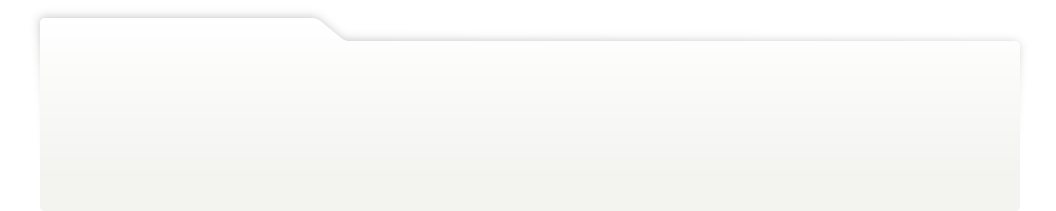
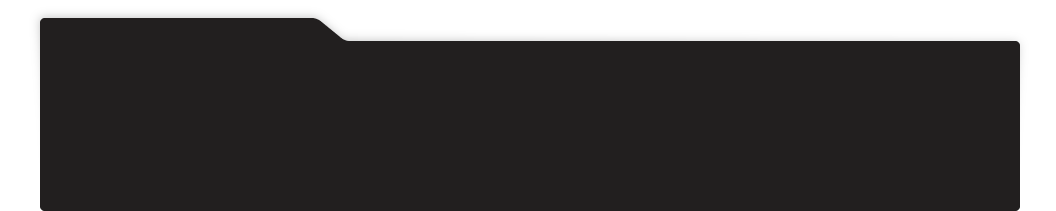
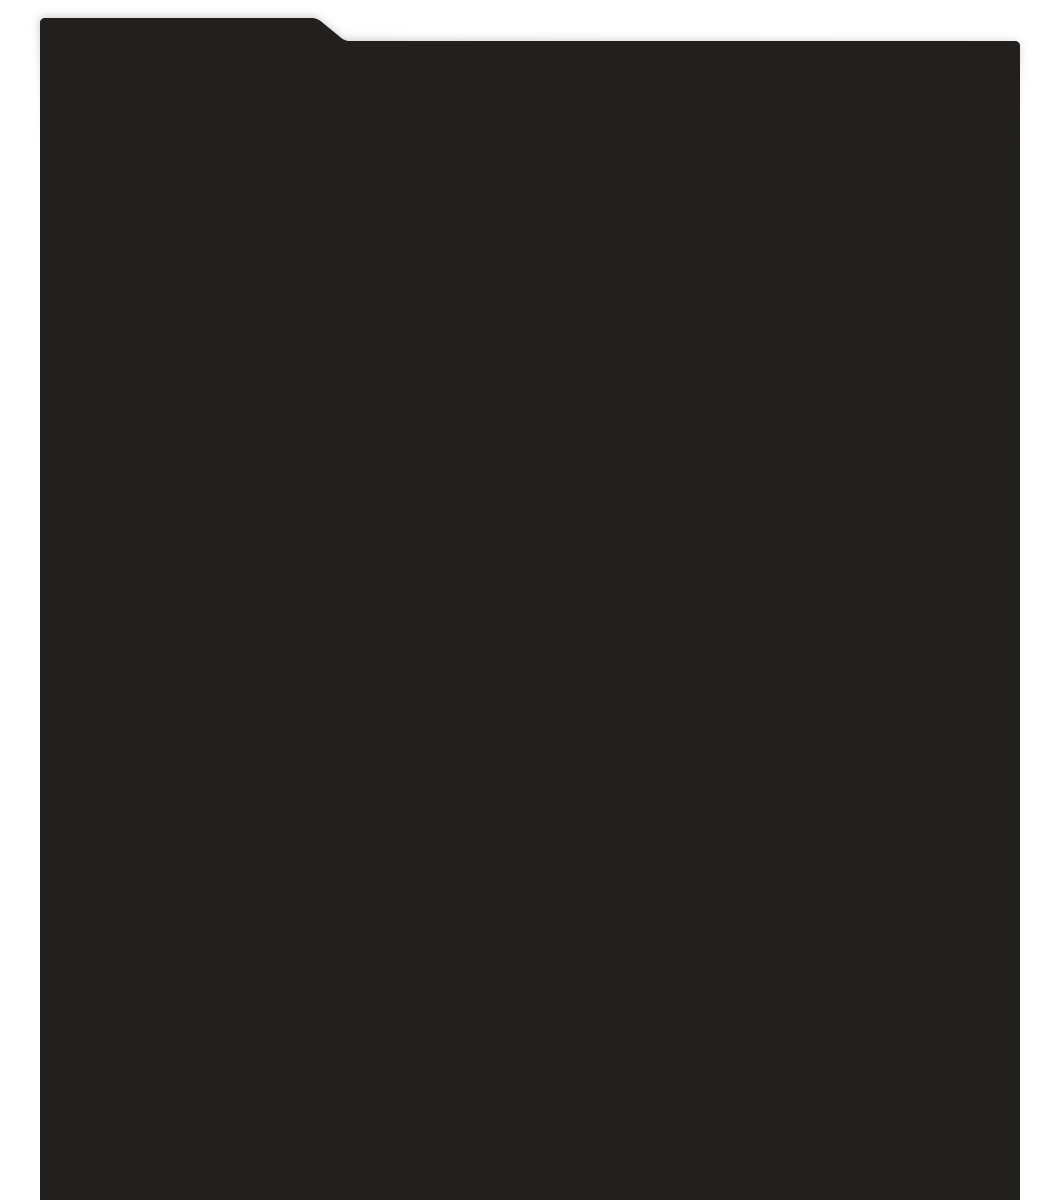
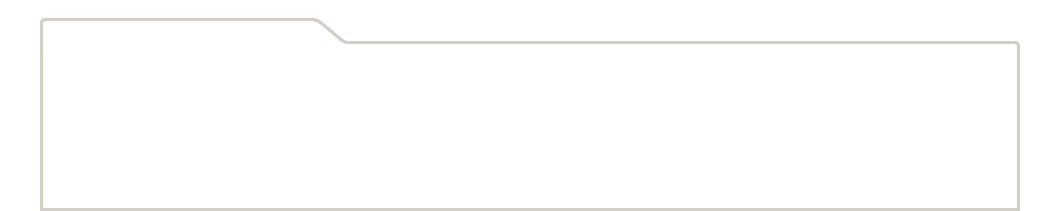
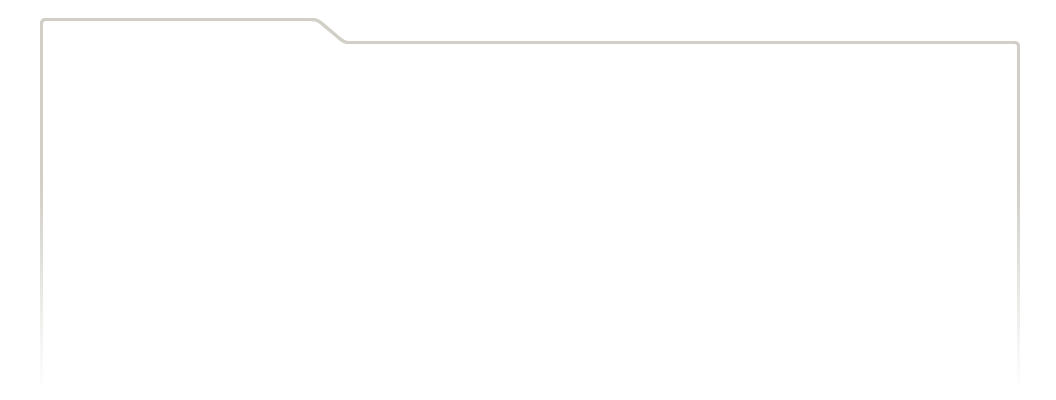
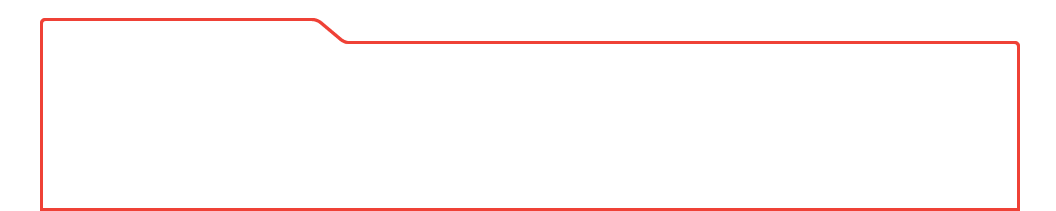
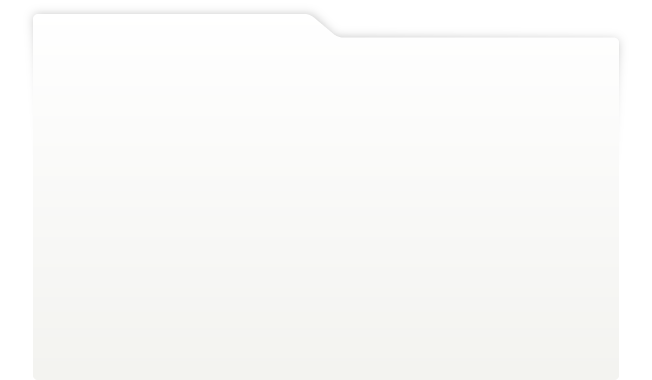
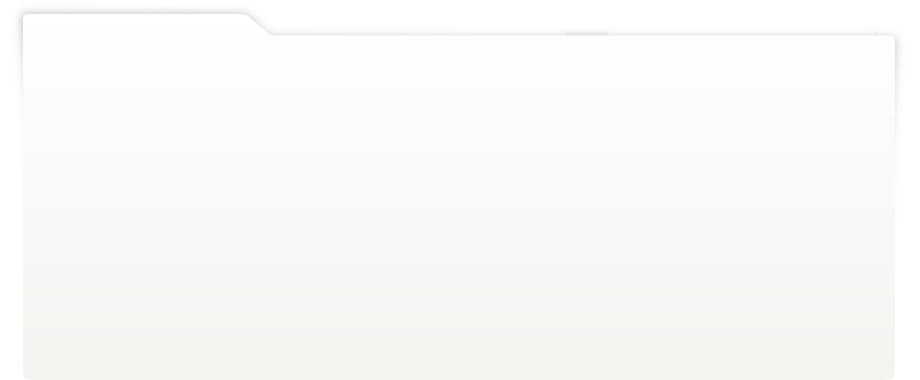
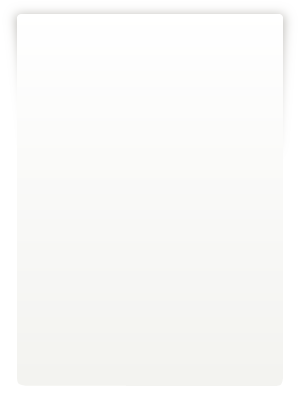
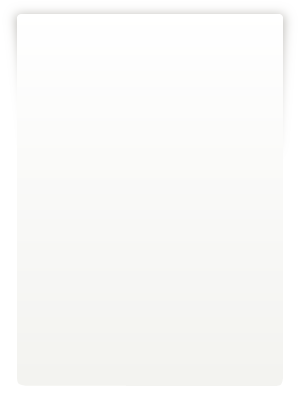
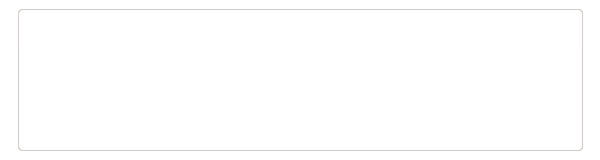
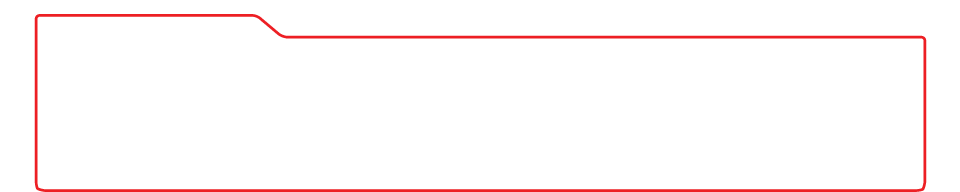
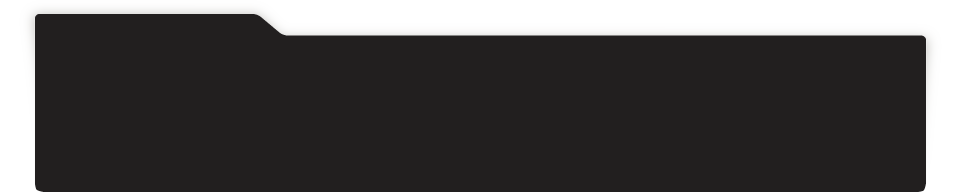
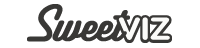
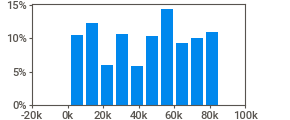
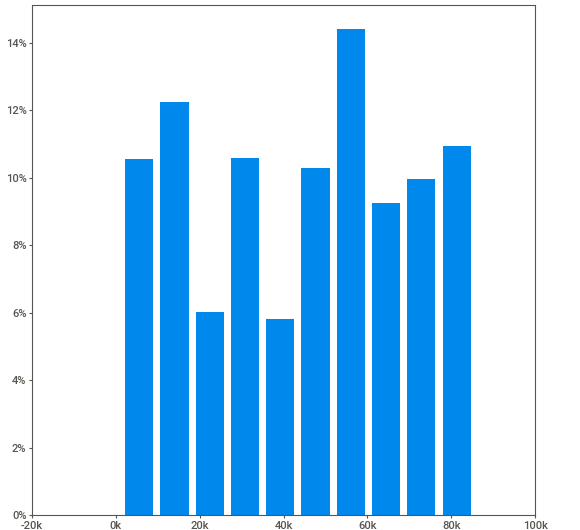
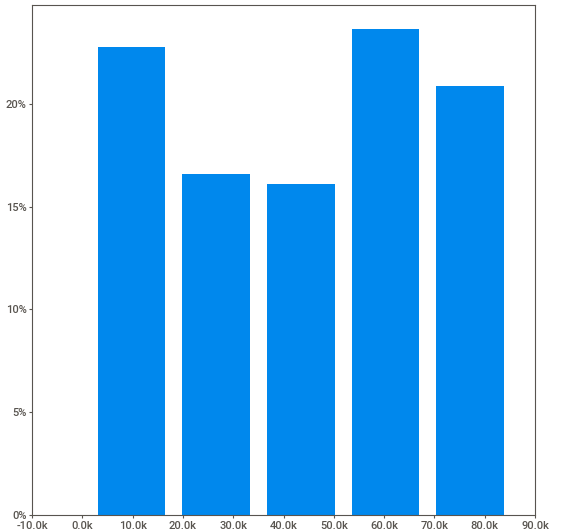
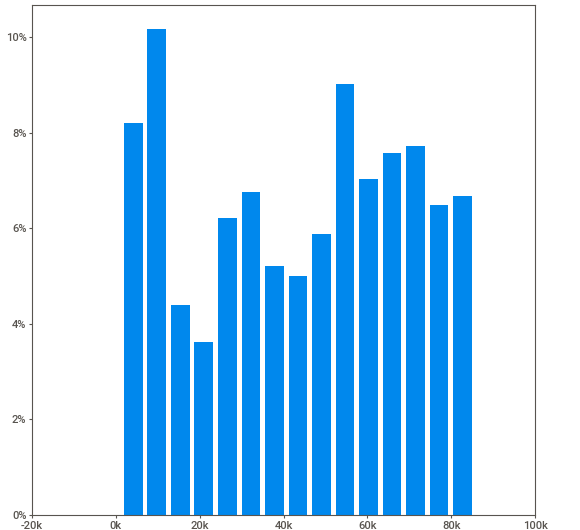
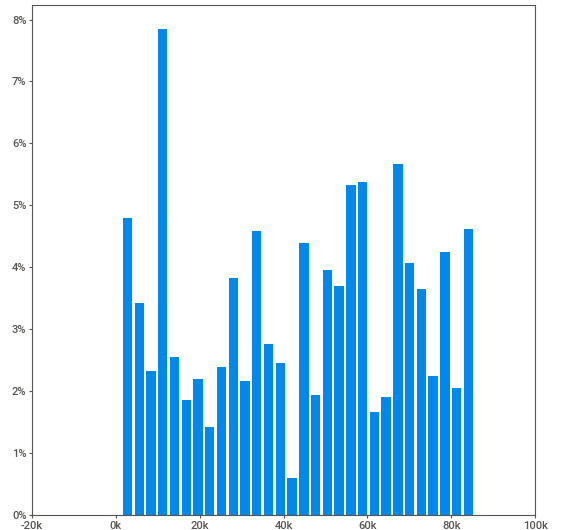
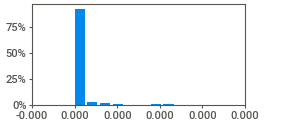
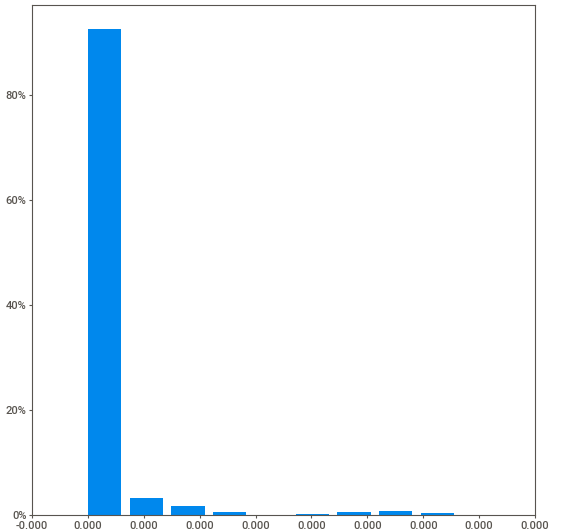
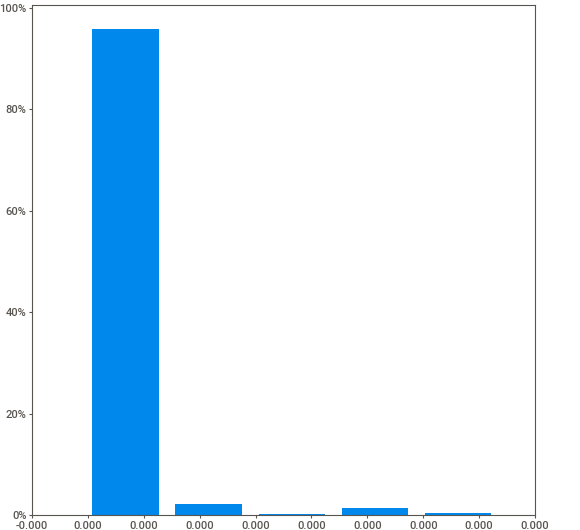
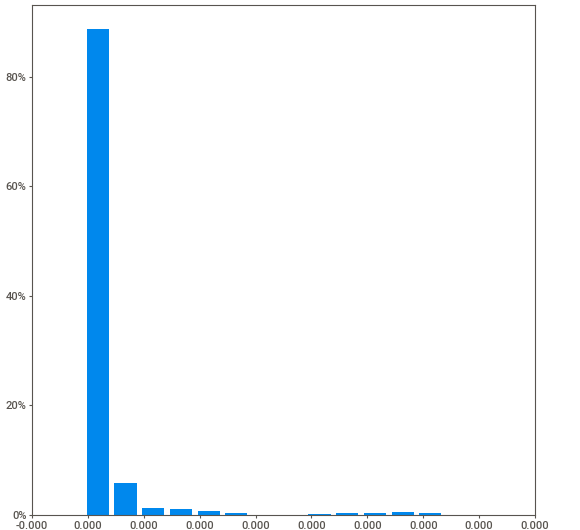
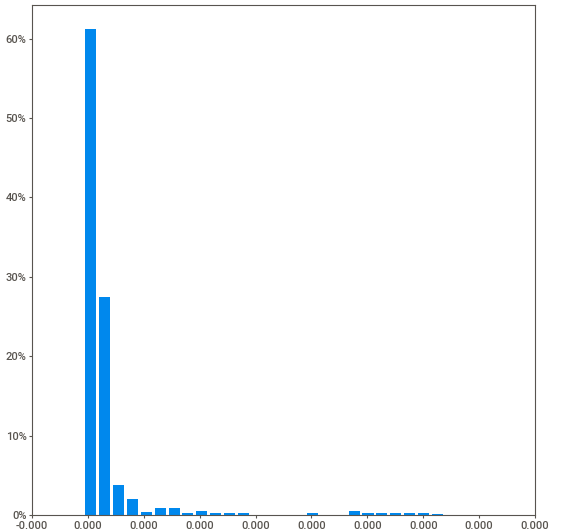
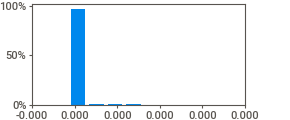
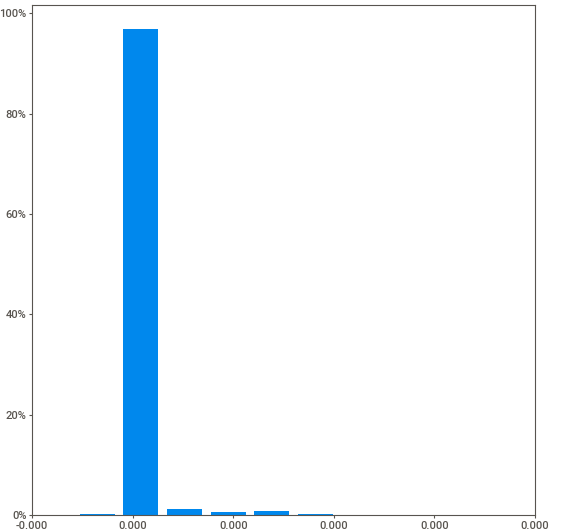
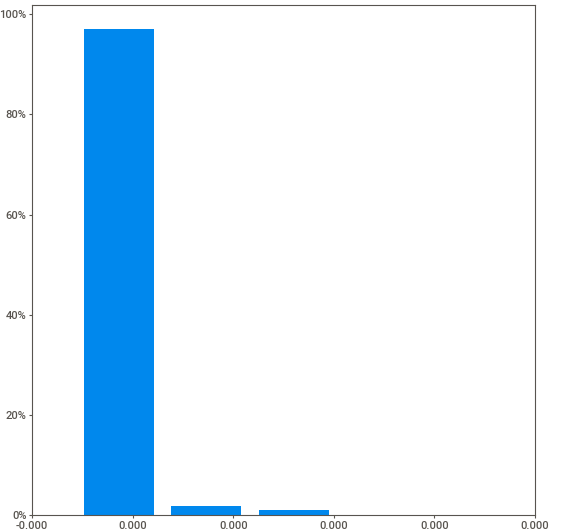
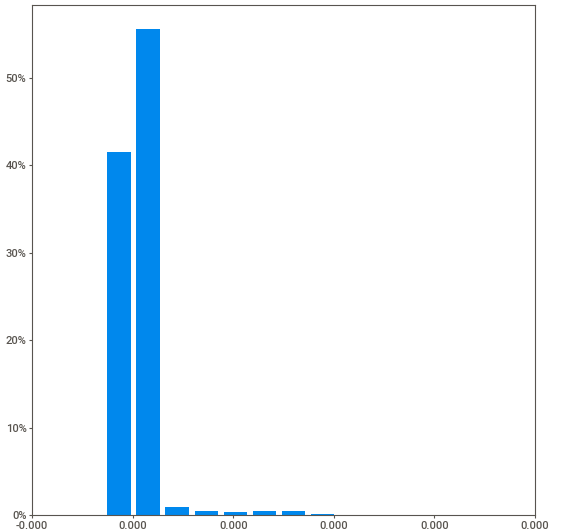
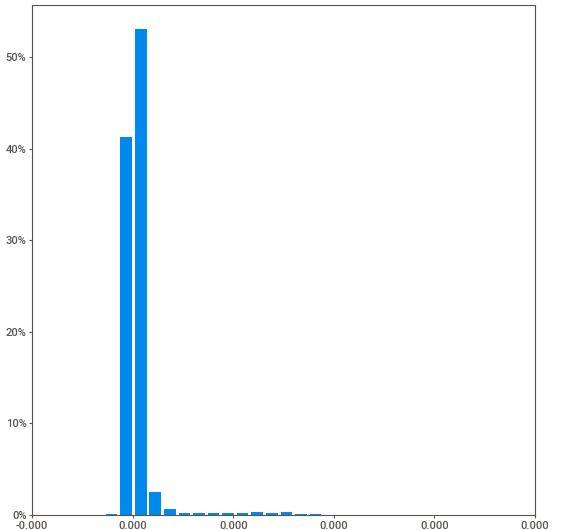
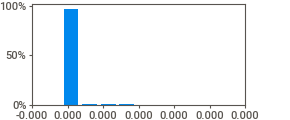
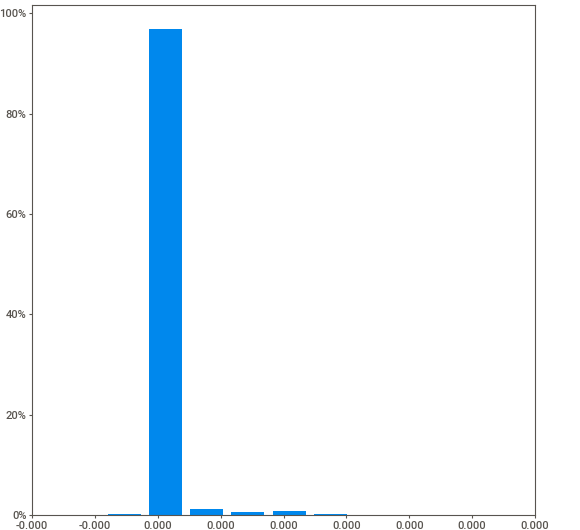
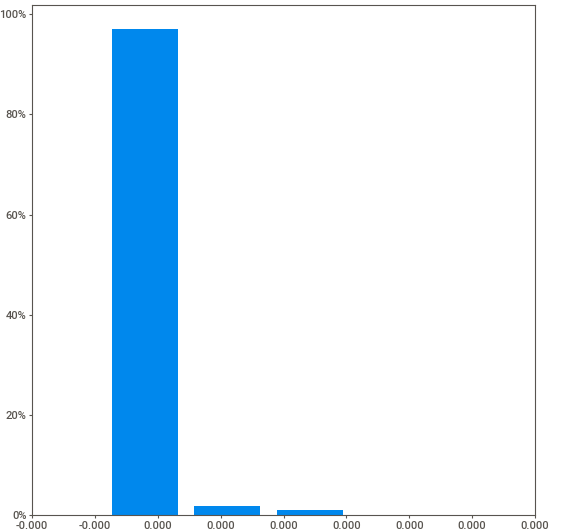
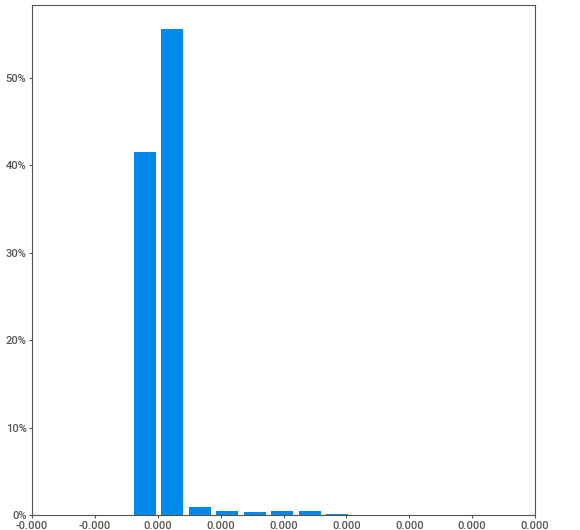
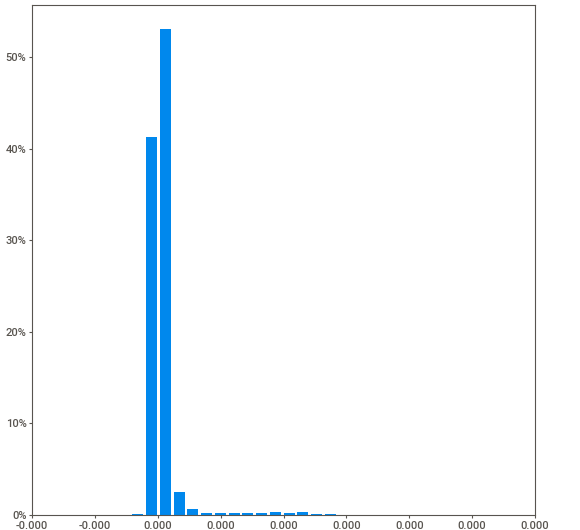
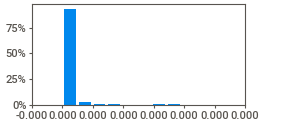
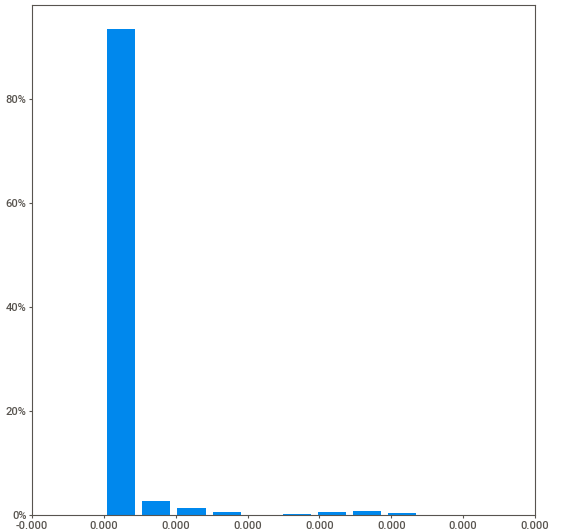
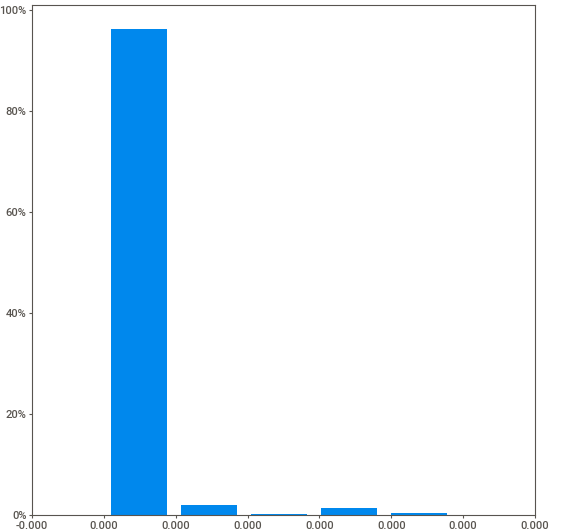
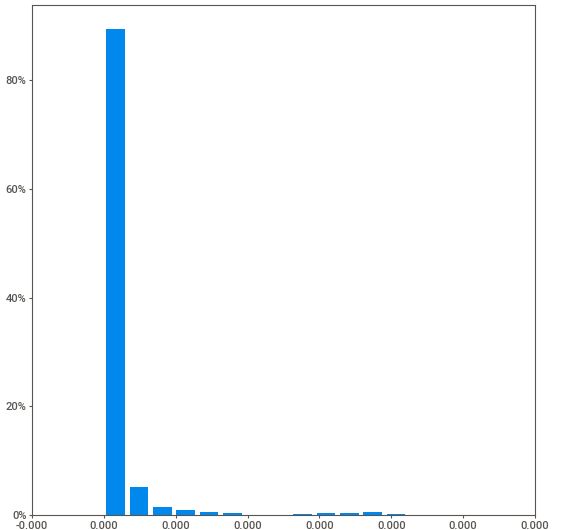
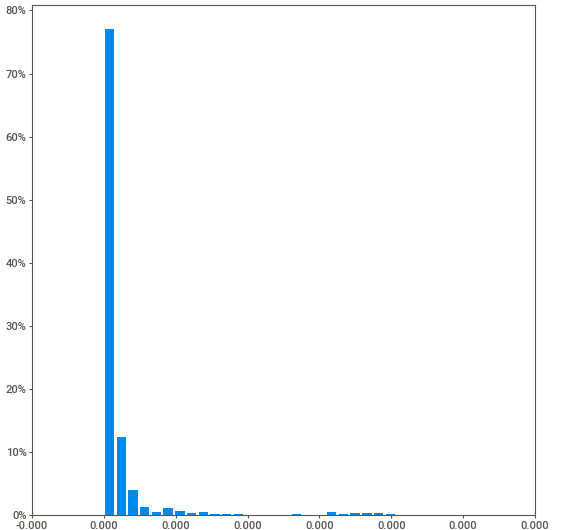
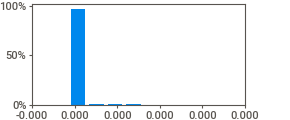
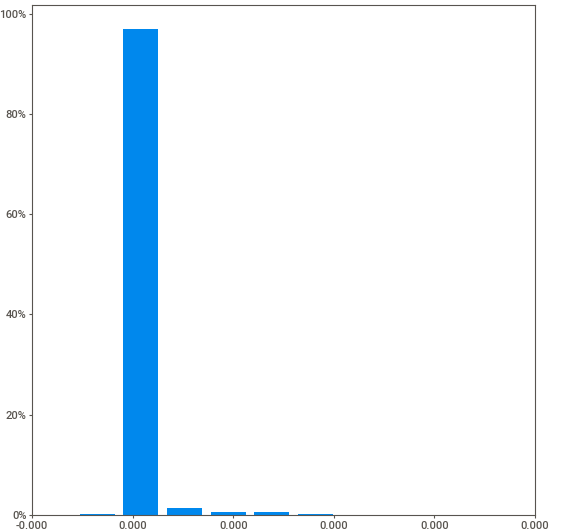
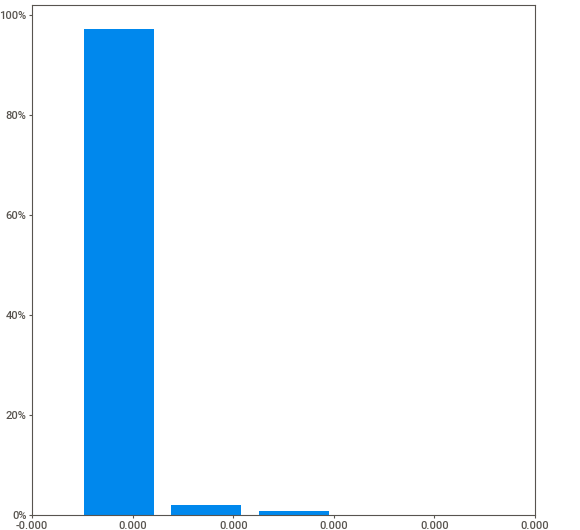
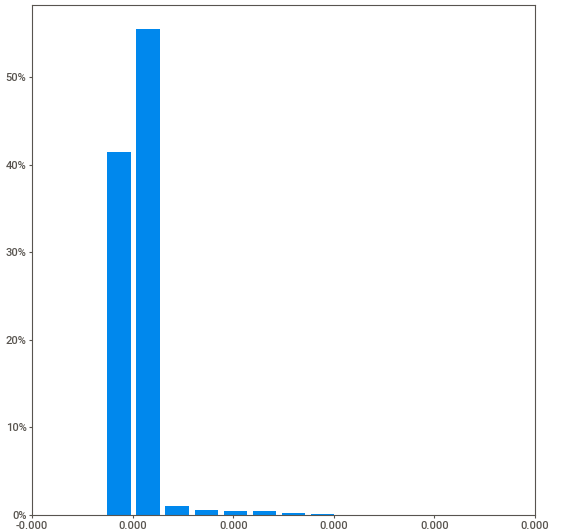
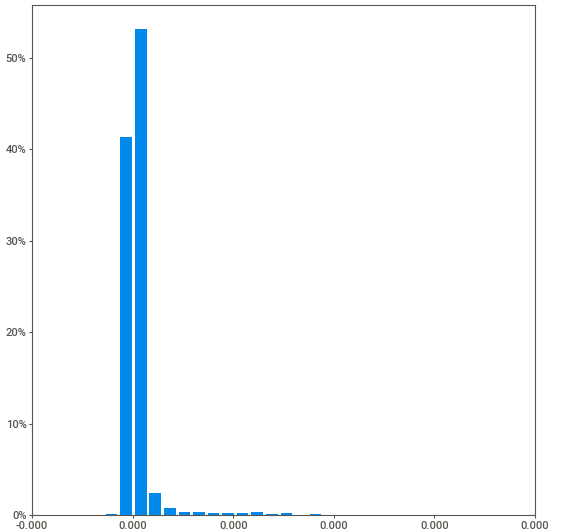
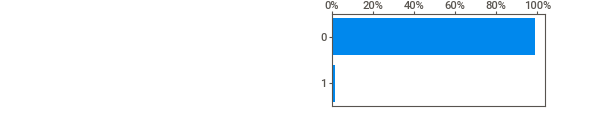
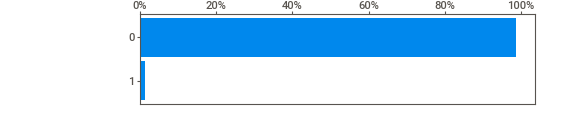
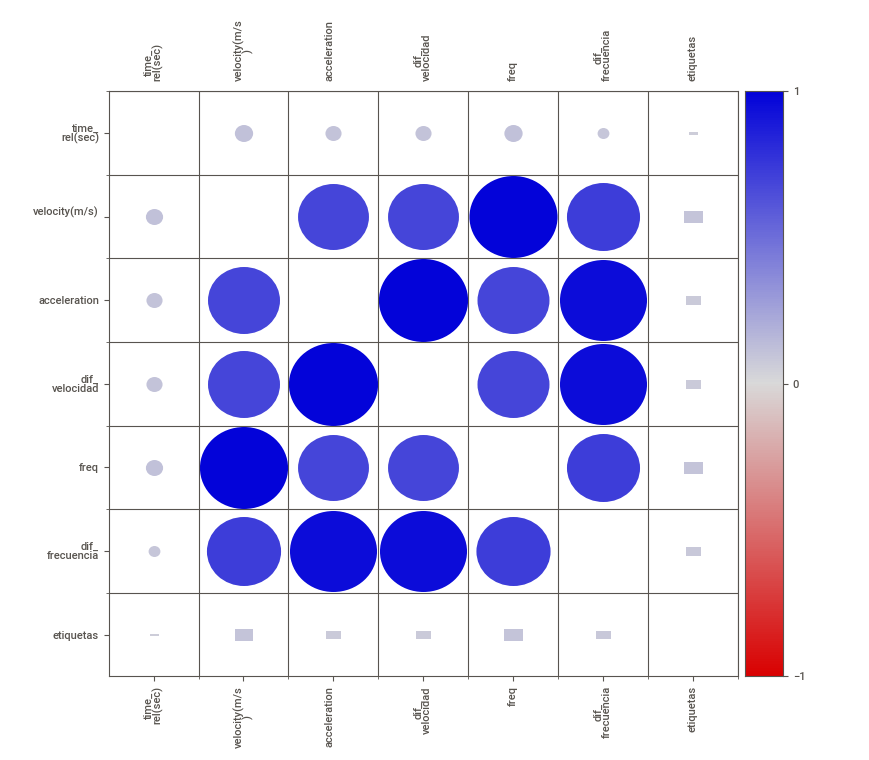
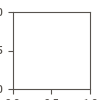

In [63]:
reporte = sv.analyze(df)
reporte.show_html("reporte_sweetviz.html")
reporte.show_notebook()

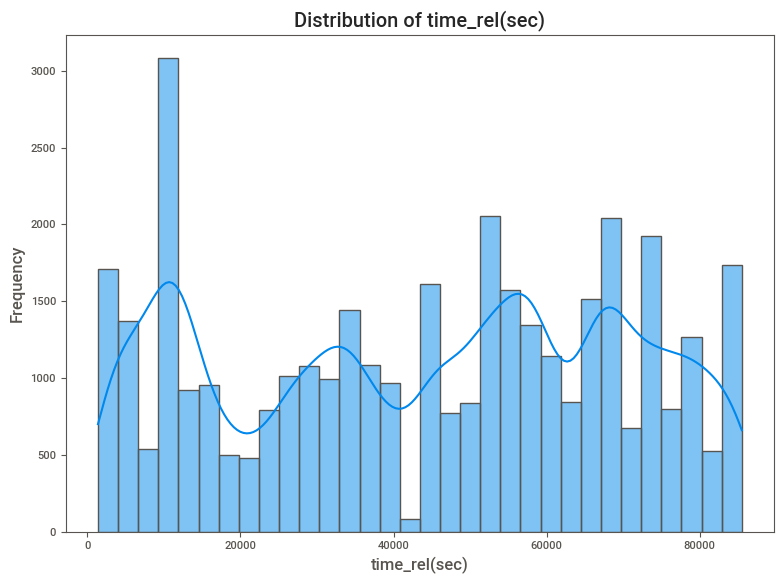

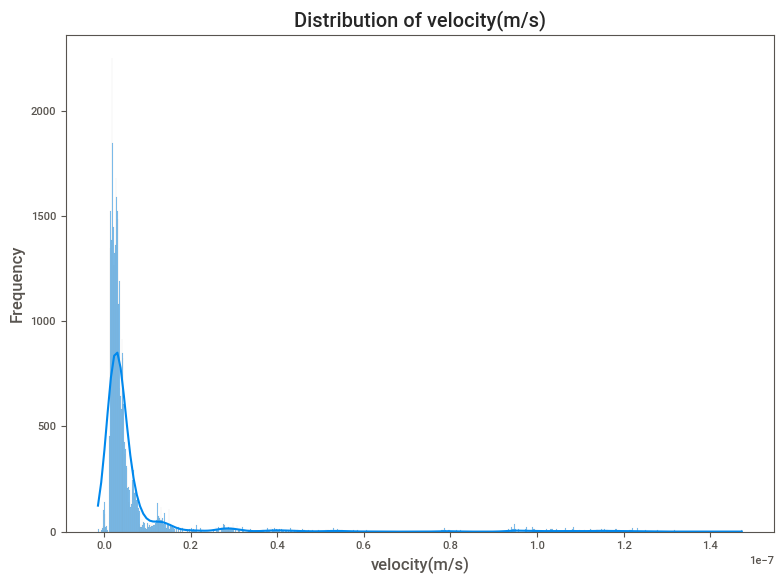

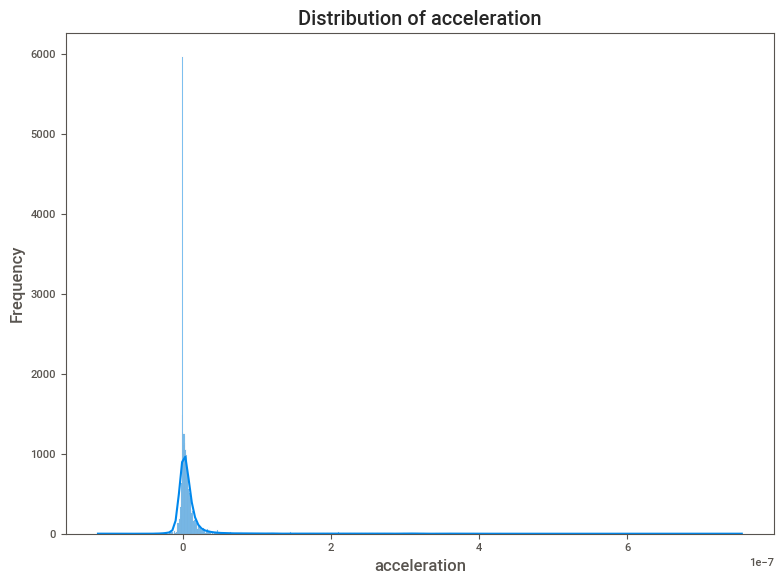

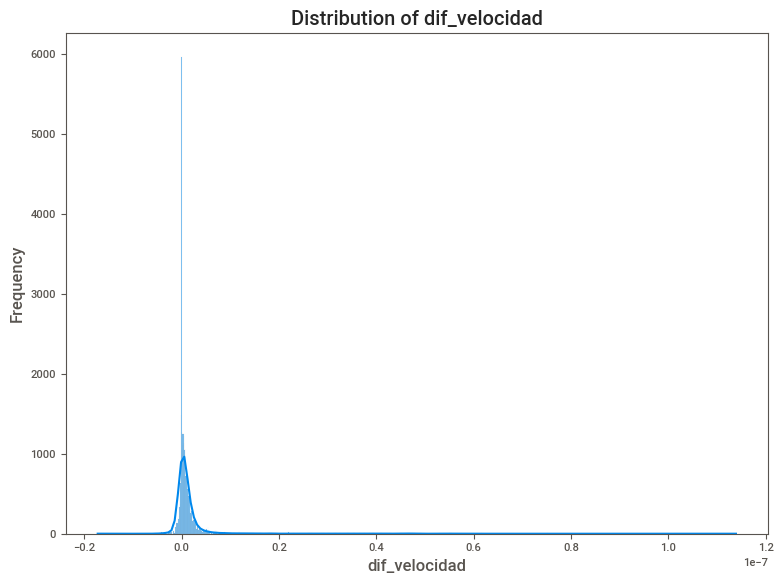

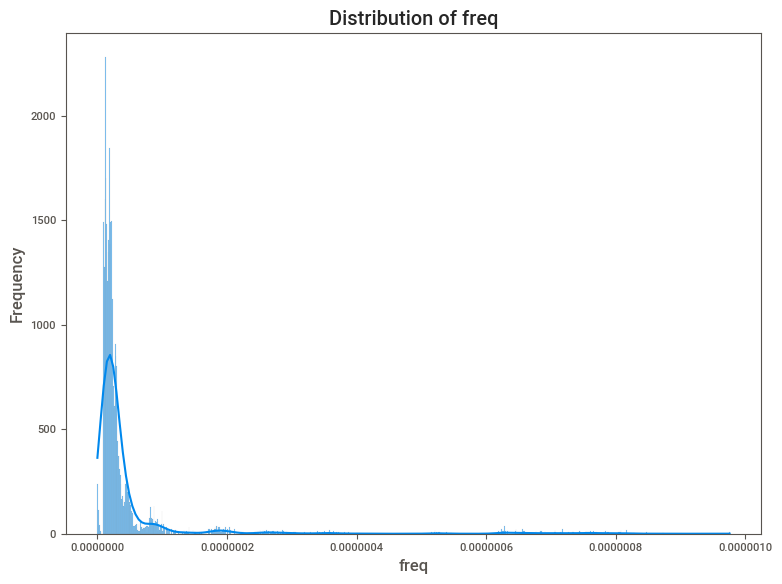

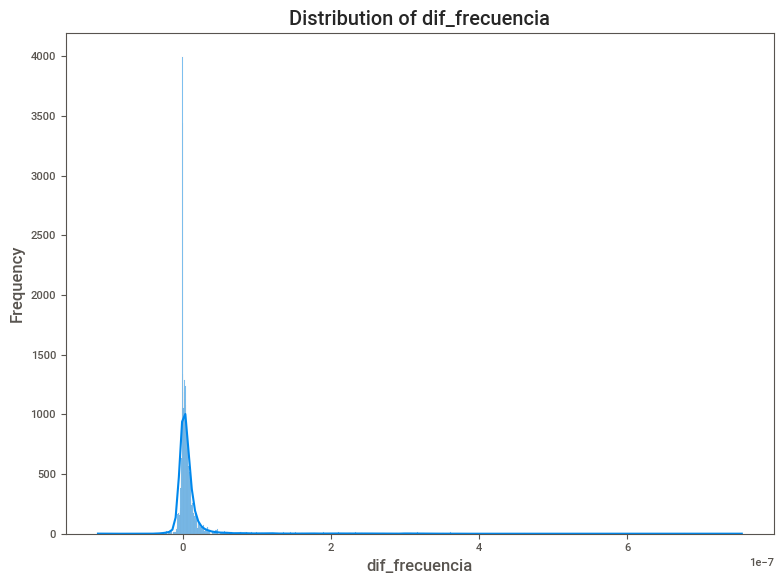

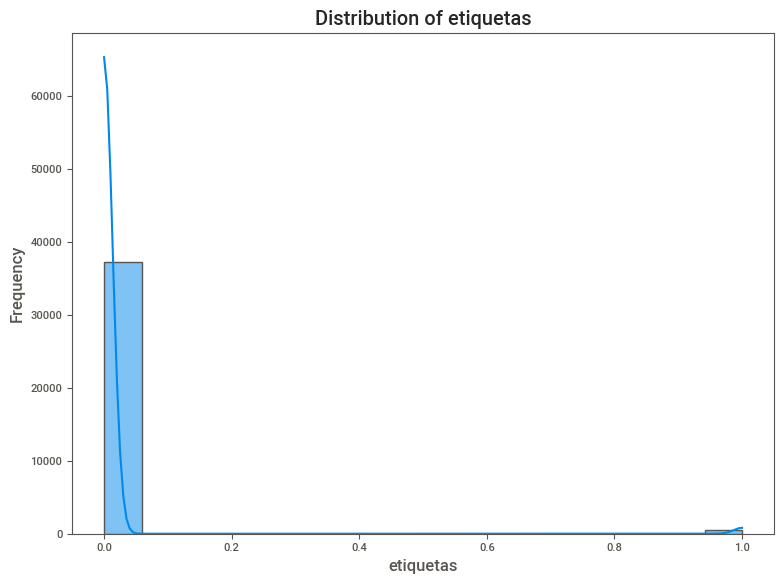

In [76]:

if not os.path.exists('descriptive_statistics_report'):
    os.makedirs('descriptive_statistics_report')


for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 6))

    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    if '(m/s)' in column:
      plt.savefig(f'descriptive_statistics_report/{column[:-5]}_histogram.png')
    else:
      plt.savefig(f'descriptive_statistics_report/{column[:-5]}_histogram.png')
    plt.show()
    plt.close()




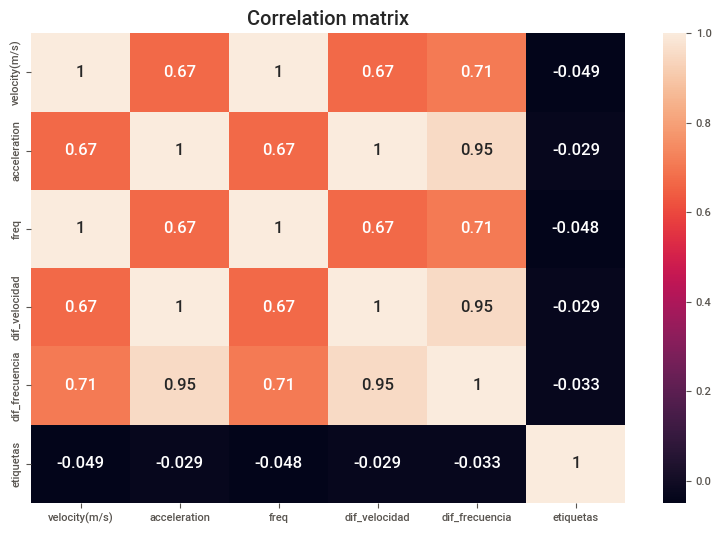

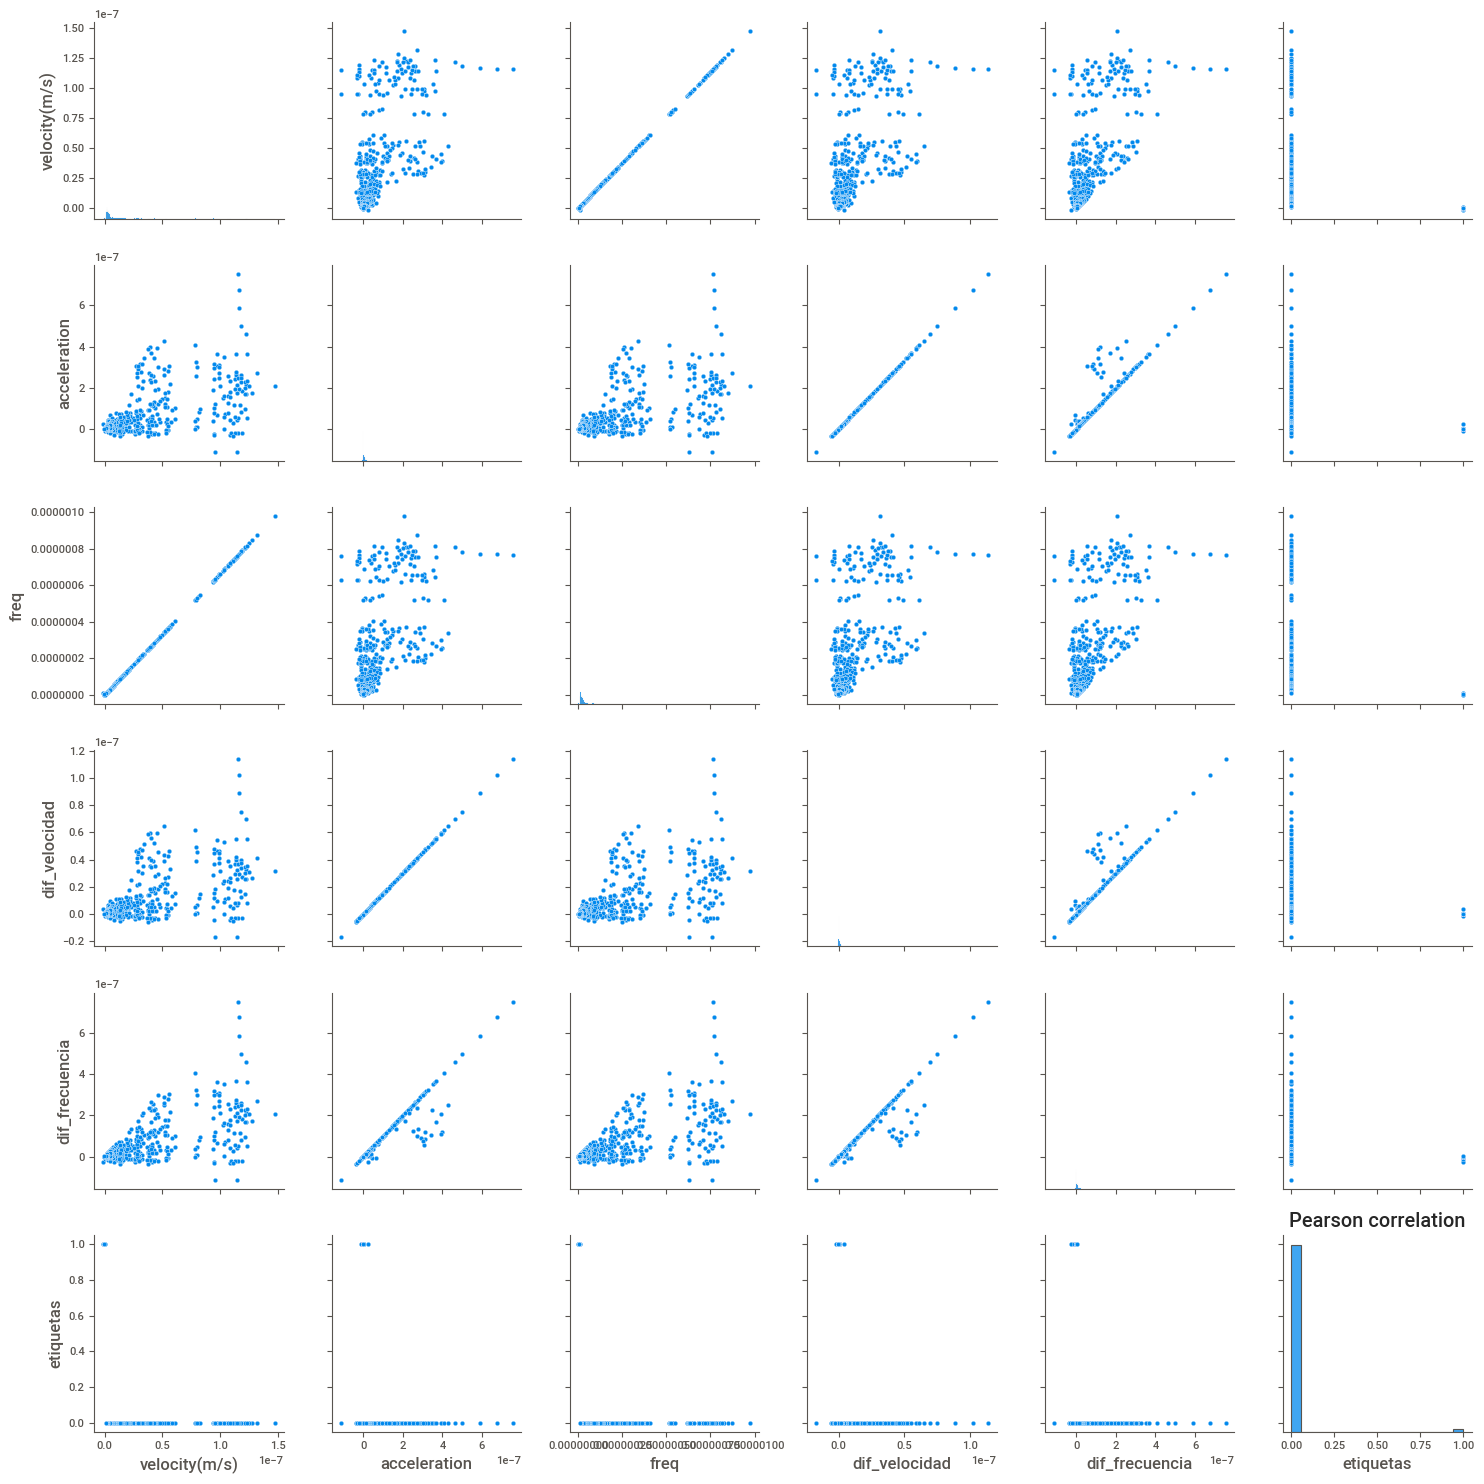

In [77]:

if not os.path.exists('descriptive_statistics_report'):
    os.makedirs('descriptive_statistics_report')

correlacion = df[['velocity(m/s)', 'acceleration', 'freq','dif_velocidad', 'dif_frecuencia','etiquetas']].corr()

sns.heatmap(correlacion, annot=True)
plt.title('Correlation matrix')
plt.tight_layout()
plt.savefig(f'descriptive_statistics_report/heatmap correlation of variables.png')

plt.show()

#correlacion de pearson, identificar cuales estan mas correlacionadas
sns.pairplot(df[['velocity(m/s)', 'acceleration', 'freq','dif_velocidad', 'dif_frecuencia','etiquetas']])
plt.title('Pearson correlation')
plt.tight_layout()
plt.savefig(f'descriptive_statistics_report/Pearson correlation.png')
plt.show()




In [107]:
print(sum(df['etiquetas']),len(df['etiquetas']),len(correctos['fecha']))

1062 85077 76
